## Set-up environment

First, we install HuggingFace Transformers.

In [1]:
!pip install -q git+https://github.com/huggingface/transformers.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


## Helper functions

Here we define some utilities, useful for working with video.

In [2]:
import base64
import functools
import os
import pickle
import ssl
import re
import tempfile

from urllib import request

import cv2
import imageio
import numpy as np
import scipy.io.wavfile

from IPython.display import HTML

from PIL import Image
from urllib.request import urlopen
import IPython

!pip install pytube
!pip install pytubefix

from pytube import YouTube
import sys
from pytubefix import YouTube
from pytubefix.cli import on_progress

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 kB 4.6 MB/s eta 0:00:00


In [3]:
def download_video(url):
  videoURL = url
  if (len(sys.argv) > 1):
      videoURL = sys.argv[1]
  #if ("youtube.com" not in videoURL):
  #    videoURL = input("Enter YouTube URL: ")
  yt = YouTube(url, on_progress_callback = on_progress)
  print(yt.title)
  ys = yt.streams.get_highest_resolution()
  filename = yt.title.replace(" ","_")
  print("Downloading YouTube File: " + yt.title)
  ys.download(filename=filename + ".mp4")


def load_poster(url):
  img = Image.open(urlopen(url))
  return img

# Utilities to open video files using CV2
def crop_center_square(frame):
  y, x = frame.shape[0:2]
  min_dim = min(y, x)
  start_x = (x // 2) - (min_dim // 2)
  start_y = (y // 2) - (min_dim // 2)
  return frame[start_y:start_y+min_dim,start_x:start_x+min_dim]

def load_video(path, max_frames=0, resize=(224, 224)):
  cap = cv2.VideoCapture(path)
  frames = []
  try:
    while True:
      ret, frame = cap.read()
      if not ret:
        break
      frame = crop_center_square(frame)
      frame = cv2.resize(frame, resize)
      frame = frame[:, :, [2, 1, 0]]
      frames.append(frame)

      if len(frames) == max_frames:
        break
  finally:
    cap.release()
  return np.array(frames) / 255.0

def to_gif(images):
  converted_images = np.clip(images * 255, 0, 255).astype(np.uint8)
  imageio.mimsave('./animation.gif', converted_images[0:15], fps=25)
  with open('./animation.gif', 'rb') as f:
    gif_64 = base64.b64encode(f.read()).decode('utf-8')
  return HTML('<img src="data:image/gif;base64,%s"/>' % gif_64)

def show_poster(url):
  IPython.display.Image(url, width = 250)

def play_audio(data, sample_rate=48000):
  scipy.io.wavfile.write('tmp_audio.wav', sample_rate, data)

  with open('./tmp_audio.wav', 'rb') as f:
    audio_64 = base64.b64encode(f.read()).decode('utf-8')
  return HTML('<audio controls src="data:audio/wav;base64,%s"/>' % audio_64)

def table(elements):
  row = ['<td>%s</td>' % el.data for el in elements]
  return HTML('<table><tr>%s</tr></table>' % ''.join(row))

## Load video and audio

Here we load a particular video, which we'll use for auto-encoding.

In [4]:
poster_url = "https://www.moriareviews.com/rongulator/wp-content/uploads/Star-Wars-Episode-V-The-Empire-Strikes-Back-1980-poster.jpg"
video_url = "https://www.youtube.com/watch?v=Dea4bypvgao"
poster = load_poster(poster_url)
download_video(video_url)
filename = "Star_Wars:_Episode_V_-_The_Empire_Strikes_Back_(1980)_Trailer_#1_|_Movieclips_Classic_Trailers"
video_path = "/content/"+filename+".mp4"
video = load_video(video_path)
plot = "The legendary saga continues as the Rebel Alliance faces increasing challenges from the mighty Galactic Empire. Luke Skywalker, Han Solo, and Princess Leia Organa confront new trials that test their courage, friendships, and beliefs. The Rebel Alliance has established a hidden base on the icy planet of Hoth, where they hope to regroup and plan their next moves against the Empire. Luke Skywalker receives a message from a familiar source, prompting him to seek further guidance in understanding his connection to the Force. Han Solo and Princess Leia's journey takes them on a dangerous path as they navigate a galaxy under Imperial control. Their actions and decisions lead to unforeseen consequences that will impact the fate of the Rebellion. Meanwhile, the dark presence of Darth Vader looms as he relentlessly pursues the Rebels while dealing with inner conflicts of his own."

# Extract audio using FFMPEG and encode as pcm float wavfile (only format readable by scipy.io.wavfile).
!yes | ffmpeg -i "$video_path"  -c copy  -f wav -map 0:a pcm_f32le -ar 48000 "$filename".wav

sample_rate, audio = scipy.io.wavfile.read(filename+".wav")
if audio.dtype == np.int16:
  audio = audio.astype(np.float32) / 2**15
elif audio.dtype != np.float32:
  raise ValueError('Unexpected datatype. Model expects sound samples to lie in [-1, 1]')


Enter YouTube URL: 
Star Wars: Episode V - The Empire Strikes Back (1980) Trailer #1 | Movieclips Classic Trailers
ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt -

In [ ]:
# Visualize inputs
table([to_gif(video), play_audio(audio)])

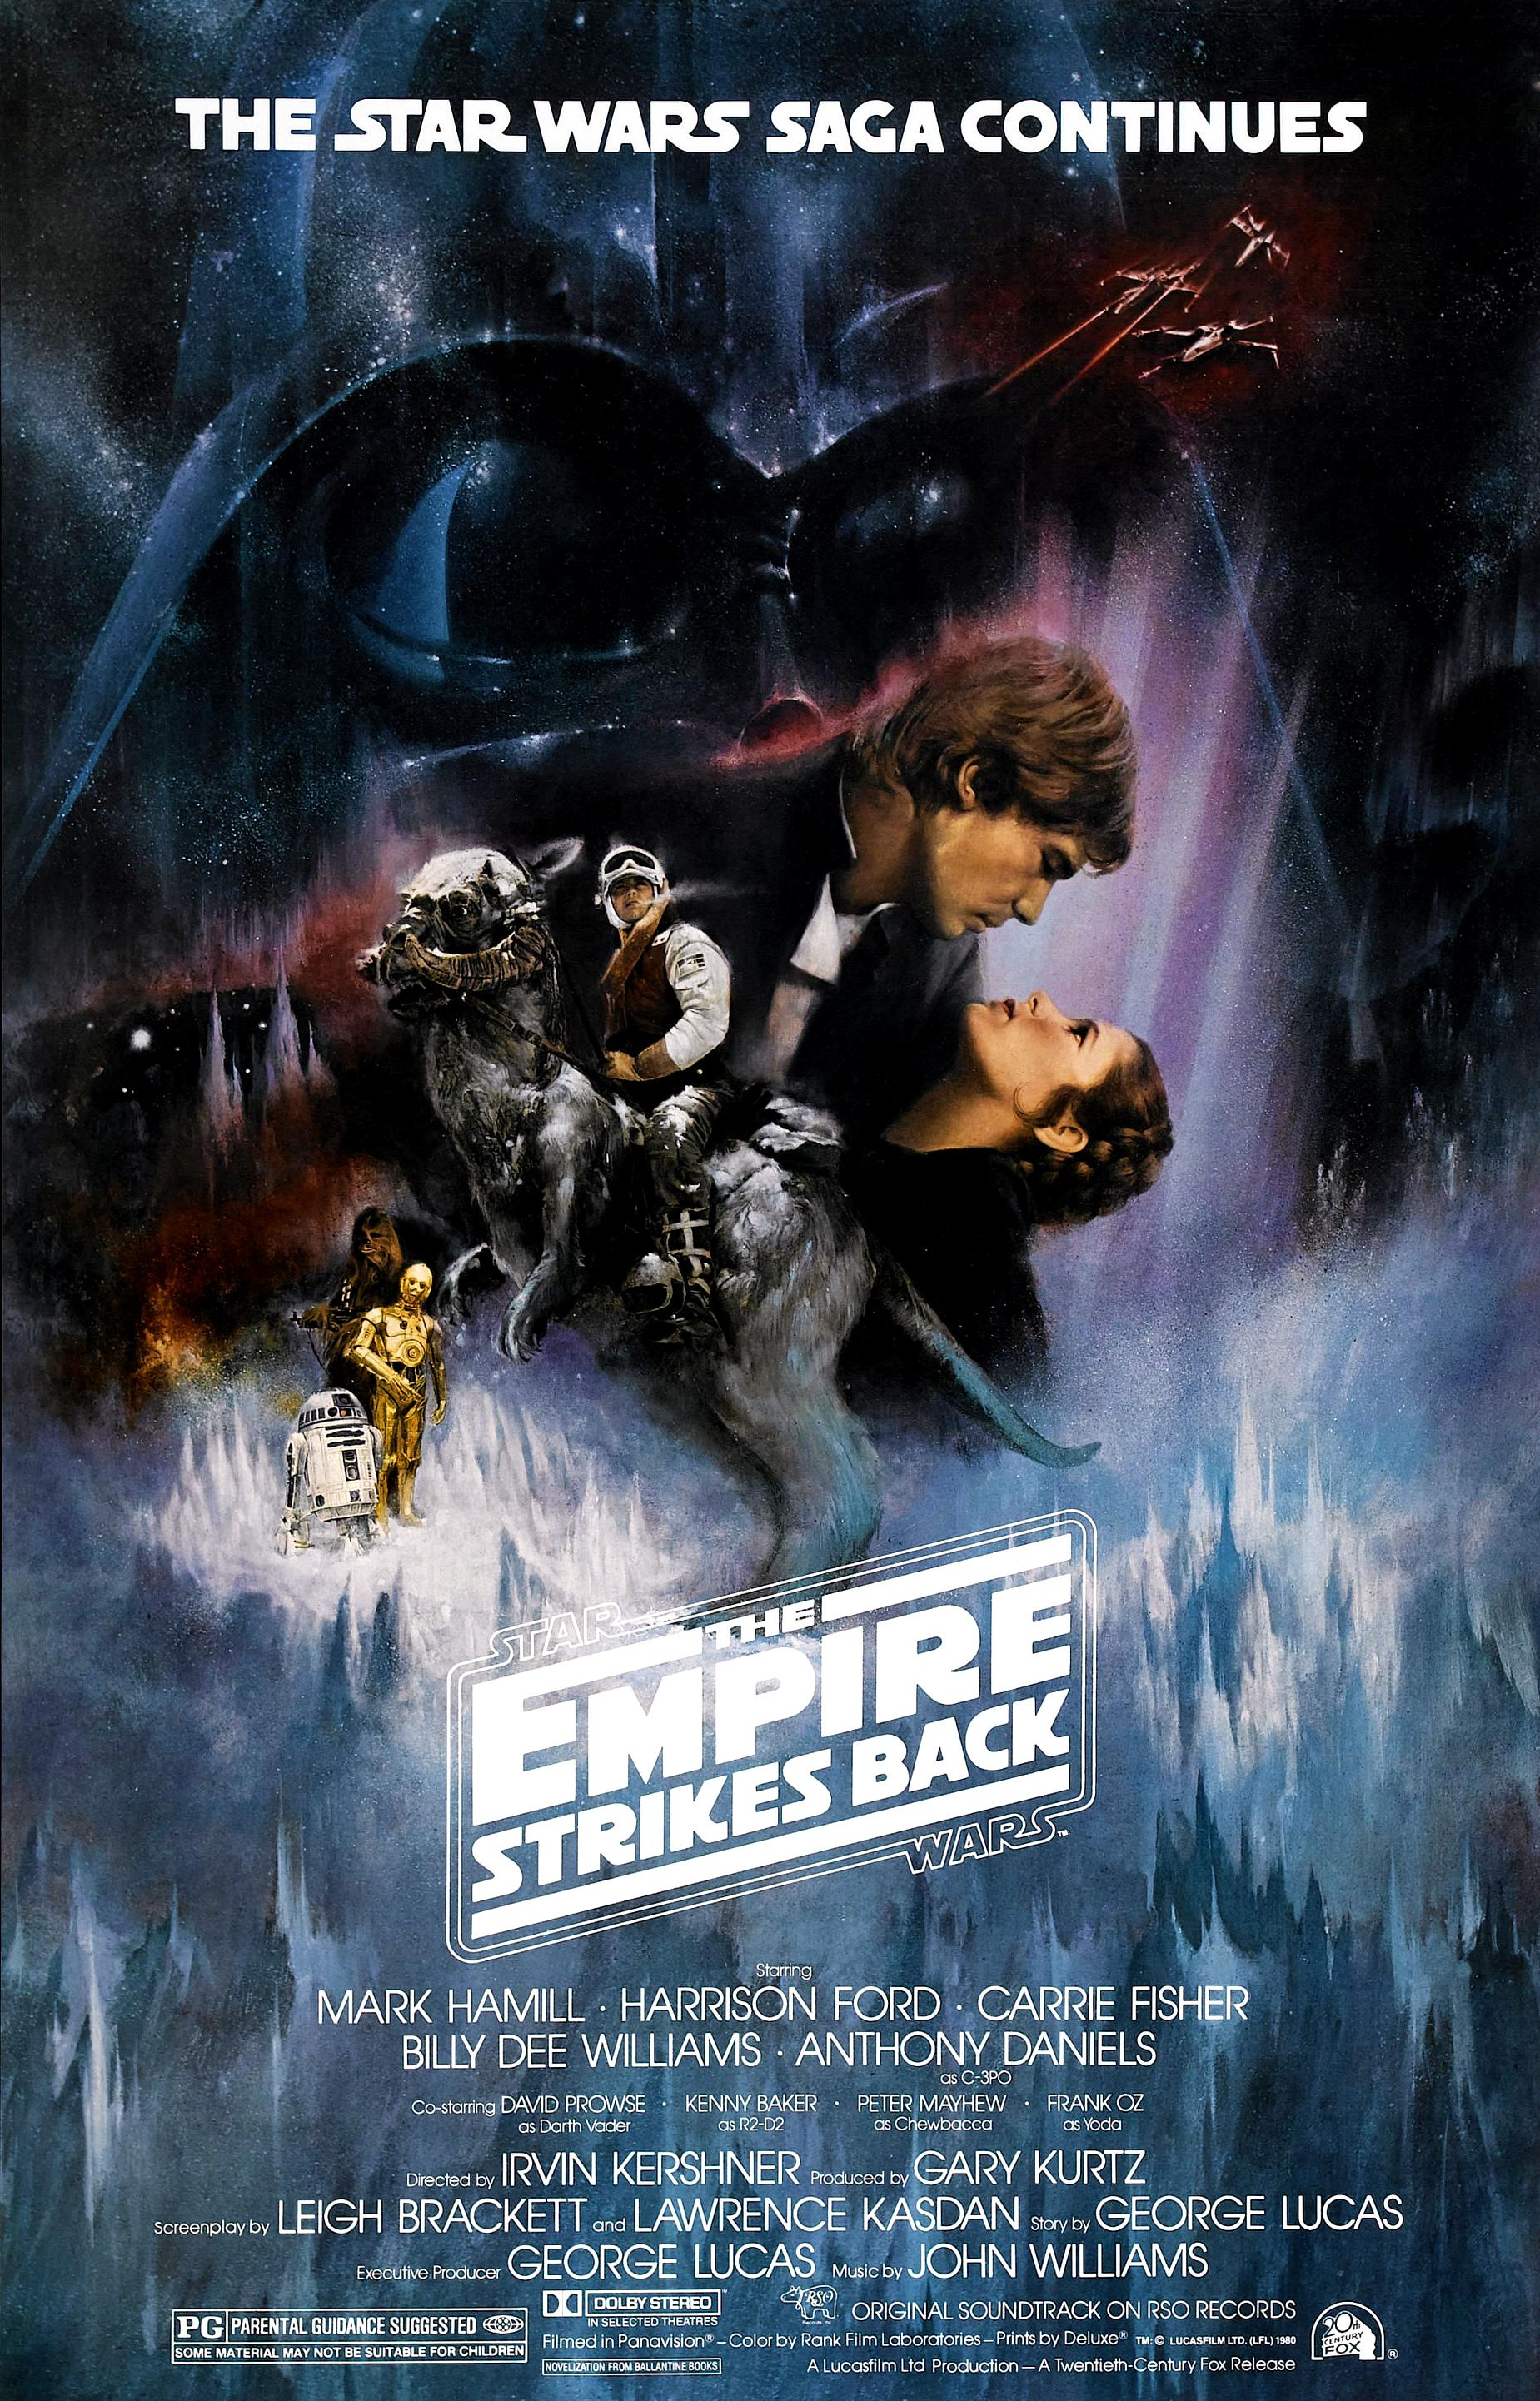

In [6]:
IPython.display.Image(poster_url, width = 250)

## Apply

Note that the entire video (i.e. all 16 frames) is used in the forward pass of the model (to perform cross-attention with the latents).

However, only certain subsampled index dimensions are used when creating the decoder queries.

In [7]:
from transformers import PerceiverForMultimodalAutoencoding
from tqdm.notebook import tqdm
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = PerceiverForMultimodalAutoencoding.from_pretrained("deepmind/multimodal-perceiver",
                                                                   low_cpu_mem_usage=True)
model.to(device)

def autoencode_video(images, audio):

  # only create entire video once as inputs
  inputs = {'image': torch.from_numpy(np.moveaxis(images, -1, 2)).float().to(device),
          'audio': torch.from_numpy(audio).to(device),
          'label': torch.zeros((images.shape[0], 700)).to(device)}

  nchunks = 128
  reconstruction = {}
  for chunk_idx in tqdm(range(nchunks)):
        image_chunk_size = np.prod(images.shape[1:-1]) // nchunks
        audio_chunk_size = audio.shape[1] // SAMPLES_PER_PATCH // nchunks
        subsampling = {
            'image': torch.arange(
                image_chunk_size * chunk_idx, image_chunk_size * (chunk_idx + 1)),
            'audio': torch.arange(
                audio_chunk_size * chunk_idx, audio_chunk_size * (chunk_idx + 1)),
            'label': None,
        }

        # forward pass
        with torch.no_grad():
          outputs = model(inputs=inputs, subsampled_output_points=subsampling)

        output = {k:v.cpu() for k,v in outputs.logits.items()}

        reconstruction['label'] = output['label']
        if 'image' not in reconstruction:
          reconstruction['image'] = output['image']
          reconstruction['audio'] = output['audio']
        else:
          reconstruction['image'] = torch.cat(
              [reconstruction['image'], output['image']], dim=1)
          reconstruction['audio'] = torch.cat(
              [reconstruction['audio'], output['audio']], dim=1)

        del outputs

  # finally, reshape image and audio modalities back to original shape
  reconstruction['image'] = torch.reshape(reconstruction['image'], images.shape)
  reconstruction['audio'] = torch.reshape(reconstruction['audio'], audio.shape)
  return reconstruction

  return None

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


config.json:   0%|          | 0.00/40.5k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/79.5M [00:00<?, ?B/s]

In [8]:
AUDIO_SAMPLES_PER_FRAME = 48000 // 25
SAMPLES_PER_PATCH = 16

# Auto-encode the first 16 frames of the video and one of the audio channels
reconstruction = autoencode_video(video[None, :16], audio[None, :16*AUDIO_SAMPLES_PER_FRAME, 0:1])

  0%|          | 0/128 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/79.5M [00:00<?, ?B/s]

""

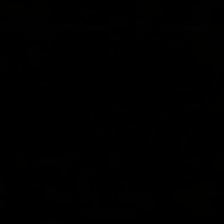

In [9]:
# Visualize reconstruction of first 16 frames
table([to_gif(reconstruction["image"][0].numpy()), play_audio(np.array(reconstruction["audio"][0].numpy()))])

In [ ]:
table([to_gif(video), play_audio(audio)])

In [11]:
# Print top 5 predicted labels
scores, indices = torch.topk(torch.softmax(reconstruction["label"], dim=1), k=5)
for score, index in zip(scores[0], indices[0]):
  print("%s: %s" % (model.config.id2label[index.item()], score.item()))

shining flashlight: 0.04847661405801773
shooting off fireworks: 0.03708017244935036
dancing ballet: 0.023962656036019325
playing paintball: 0.020369013771414757
using remote controller (not gaming): 0.014885376207530499
